# Homework nr. 1 - data visualization (deadline 25/10/2018)

In short, the main task is to download data on theses defended at CTU from the Internet, store them in pandas Data Frame and then visualize some hidden information.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. Thinking of how to visualize the data is an important part of data visualization! ;)

## What are you supposed to do:

  1. Browse the web https://dspace.cvut.cz/?locale-attribute=en and find out how to download data on Bachelor and Master theses.
  2. Download or scrape the data such that for each thesis you know the following:
    * Faculty name, department name, thesis title, thesis type (bachelor/master), supervisor name, reviewer name, year (or date) of the defence, study programme and discipline, link to a webpage with details.
  3. Store these data in one _csv_ file (should be handed in along with this notebook).
  4. Use tools available for Python to plot charts and tables to visualize/display this information:
    * Number of defended theses per year for CTU/Faculties. Distinguish the type of thesis.
    * Find the departments/study programmes/supervisors/reviewers with highest numbers of thesis and come up with some nice plots and tables to depict their numbers.
    * Mean/median/minimum/maximum number of supervised theses per year for faculties.
    * Number (or fraction) of theses supervised by people with various degrees (Bc./Ing./Ph.D./ ...).

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Use http://beakerx.com to make your notebook interactive in a meaningful way.
  * Come up with some other reasonable and interesting views of data.
  * Use your data to create an interactive webpage (HTML + JavaScript).

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import sklearn as skit
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup as BS
import time

%matplotlib inline
matplotlib.style.use('ggplot')

In [66]:
"""
Each link for each thesis has the format 
https://dspace.tul.cz/handle/NUMBER1/NUMBER2, this function gets NUBMER2
for each relevant link on the website specified by url and returns them
in a list.
Param offset is needed because if an offset is given in the url, the
relevant links shift by one position.
"""
def getInfoFromURL (url, offset = False):
    #List to store each NUMBER2
    id_links = []
    #create http get request
    response = requests.get(url)
    #use BeautifulSoup to "prettify" the content of response
    soup = BS(response.content, 'html.parser')
    #Search for all relevant links in soup Object
    links = [a.get('href') for a in soup.find_all('a', href = True)]
    #Check whether offset is needed or not
    if (offset):
        #get relevant links
        rel_links = links[8:28]
    else:
        #get relevant links
        rel_links = links[7:27]
    #get NUMBER2 from each relevant link
    for st in rel_links:
        id_links.append(st.split('/')[-1])
    return id_links

In [67]:
"""
Function to get relevant Metadata (given by keys) 
from a full item record(given by url).
"""
def getDataFromURL(url, keys):
    #Dictionary to store relevant info for each key in keys
    data = {}
    #create http get request
    response = requests.get(url)
    #use BeautifulSoup to "prettify" the content of response
    soup = BS(response.text, 'html.parser')
    #Find relevant informations in the soup Object
    table = soup.find("table")
    rows = table.find_all('tr')
    #store link in Dict
    data['link'] = url
    #Iterate over every Information on the full item record and store the 
    #relevant ones given by keys
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        if (cols[0] in keys) and(cols[-1] != 'en'):
            data[cols[0]] = cols[1]
    #Store NaN for each missing Info in the full item record
    for key in keys:
        if not key in data:
            data[key] = np.NaN
    return data

In [4]:
#takes roughly 4 minutes
start_time = time.time()
url = 'https://dspace.tul.cz/handle/15240/20928/recent-submissions?offset={}'

#list to store the different IDs for each link
id_links = []

#5878 entries in total, 20 entries per page => 294 hppt requests needed
for i in range(0,294):
    #adjust url corresponding to the needed offset. offset determines which elements are shown
    temp_url = url.format(i*20)
    #When offset is not changed, the http response returns slightly different data
    if(i == 0):
        temp=getInfoFromURL(temp_url, offset=False)
        id_links = id_links + temp 
    else:
        temp=getInfoFromURL(temp_url, offset=True)
        id_links = id_links + temp
#Delete last 3 entries from id_links which are not IDs
del id_links[-3:]
#store list
%store id_links
print(id_links)
print("%s seconds" %(time.time()-start_time))

Stored 'id_links' (list)
['32245', '26574', '26572', '26569', '26568', '26567', '26565', '26561', '26560', '26559', '26557', '26554', '26551', '26550', '26546', '26545', '26543', '26539', '26537', '26535', '26532', '26531', '26526', '26525', '26524', '26523', '26499', '26496', '26495', '26493', '26491', '26490', '26488', '26480', '26478', '26251', '26253', '26254', '26252', '26211', '26232', '26217', '26222', '26219', '26234', '26071', '26089', '26061', '25928', '25922', '25923', '25924', '25925', '25926', '25929', '25930', '25981', '25977', '25982', '25976', '25983', '25980', '25979', '25978', '26030', '25937', '25935', '25933', '25931', '25939', '25934', '25938', '26046', '26044', '26065', '26059', '26050', '26060', '26062', '26054', '26066', '25913', '25917', '25920', '25916', '25914', '25921', '25919', '25915', '25975', '25969', '25970', '25974', '25972', '25973', '25971', '25967', '25968', '26022', '26023', '26027', '26024', '26028', '26029', '26021', '26026', '26025', '25907', '2

In [88]:
%store -r id_links
#takes roughly one hour
start_time = time.time()
url = 'https://dspace.tul.cz/handle/15240/{}?show=full'
#specify needed informations from full item record
#using advisor and author in place for supervisor and reviewer
words=['dc.contributor.advisor', 'dc.contributor.author', 
       'dc.title', 'dc.degree.level', 'dc.date.defense','local.faculty', 
       'local.department.abbreviation', 'local.degree.programme', 
       'local.degree.discipline', 'link']
#List to store all returned Dicts
data_all = []
#Loop over every number in id_links, go the the url and scrape the 
#relevant data
for link in id_links:
    #Get Data
    data_all.append(getDataFromURL(url.format(link), words))
    
#create panda DataFrame from List of dicts
df = pd.DataFrame(data_all)
#store Dataframe
df.to_csv('Scrape.csv')
#%store df
display(df)
print("Total :%s seconds" %(time.time()-start_time))


Stored 'df' (DataFrame)


dc.contributor.advisor  \
0                                                   NaN   
1                                  Kovařík Zdeněk, Mgr.   
2                        Nádvorníková Lenka, Mgr. Ph.D.   
3                      Zágoršek Kamil, doc. RNDr. Ph.D.   
4                                Šmída Jiří, Mgr. Ph.D.   
5                              Drápela Emil, Mgr. Ph.D.   
6                              Drápela Emil, Mgr. Ph.D.   
7                                Karásková Nicola, M.A.   
8                                    Bjorke Alena, Mgr.   
9                             Muffett Christopher, M.A.   
10                             Drápela Emil, Mgr. Ph.D.   
11                               Šmída Jiří, Mgr. Ph.D.   
12          Podzimek Michal, PaedDr. ICLic. Th.D, Ph.D.   
13                             Jeřábek Petr, Mgr. Ph.D.   
14                     Kasperová Dana, doc. PhDr. Ph.D.   
15                         Kiryková Simona, PhDr. Ph.D.   
16                        Portmann Kateřina, Mgr. Ph.D.   
17                             Drápela Emil, Mgr. Ph.D.   
18                             Drápela Emil, Mgr. Ph.D.   
19                              Helikarová Eliška, Mgr.   
20                           Koudelková Eva, Mgr. Ph.D.   
21                        Konvalinková Jana, MgA. Ph.D.   
22                Hejna Dalibor, RNDr. PhDr. MTh. Ph.D.   
23                             Drápela Emil, Mgr. Ph.D.   
24                                    Smrž Pavel, PhDr.   
25                        Brožová Doubková Andrea, Mgr.   
26                       Paukertová Jana, PaedDr. Ph.D.   
27                          Anděl Petr, doc. RNDr. CSc.   
28                        Vykoukalová Věra, PhDr. Ph.D.   
29    Škaloudová - Puchmajerová Lucrezia, Mgr. A. Ph.D.   
...                                                 ...   
5847                                    Koudelková, Eva   
5848                                    Vávra, Jaroslav   
5849                                        Šmída, Jiří   
5850                                   Šaffková, Zuzana   
5851                                   Tumis, Stanislav   
5852                                   Nišponská, Magda   
5853                                  Stejskal, Bohumil   
5854                                        Anděl, Petr   
5855                       Václavíková, Helšusová Lenka   
5856                                   Sluková, Květuše   
5857                                   Krausová, Andrea   
5858                                Vrchovecká, Pavlína   
5859                                         Kříž, Jiří   
5860                                       Horák, Josef   
5861                                     Umlauf, Václav   
5862                                       Trešl, Filip   
5863                                      Hložková, Eva   
5864                                     Popková, Klára   
5865                                      Šanda, Zdeněk   
5866                           Brožová Doubková, Andrea   
5867                                      Šanda, Zdeněk   
5868                                   Matouchová, Naďa   
5869                                     Novotný, Pavel   
5870                                        Vacek, Jiří   
5871                                 Pejřimovská, Jitka   
5872                                Bubeníčková, Zuzana   
5873                                   Sluková, Květuše   
5874                                   Mactavish, Kevin   
5875                                   Mactavish, Kevin   
5876                                  Sulovská, Jarmila   

       dc.contributor.author dc.date.defense dc.degree.level  \
0                Saic, Tomáš             NaN             NaN   
1          Humlová, Kateřina       2018-6-11             Bc.   
2             Ženíšková, Eva        2018-6-7            Mgr.   
3         Tarasová, Kateřina       2018-6-12             Bc.   
4            Řádová, Martina       2018-6-11          

Total :4175.568784952164 seconds


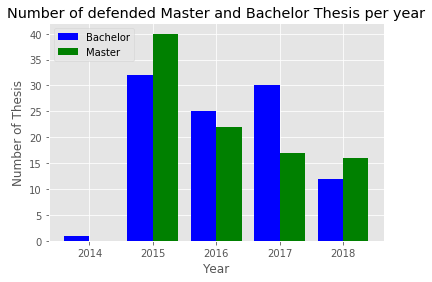

In [68]:
from datetime import datetime

#%store -r df
#Open csv with scraped data
df = pd.read_csv('Scrape.csv', encoding = 'utf-8')

#Create dataframes where only Bachelor and Master Thesis are present
bsc = df[df['dc.degree.level'] == 'Bc.']
msc = df[df['dc.degree.level'] == 'Mgr.']

#Count the number of defended Bachelor and Master Thesis for each date
bsc_count = bsc.groupby('dc.date.defense').size().sort_values(ascending=False).reset_index(name='dc.degree.level')
msc_count = msc.groupby('dc.date.defense').size().sort_values(ascending=False).reset_index(name='dc.degree.level')

#Rename for merge
bsc_count.rename(columns = {'dc.degree.level' : 'Bachelor_Count'}, inplace = True)
msc_count.rename(columns = {'dc.degree.level' : 'Master_Count'}, inplace = True)

#Merge the two dataframes
merg = pd.merge(bsc_count, msc_count, on = 'dc.date.defense', how='outer').set_index('dc.date.defense')

#Delete first entry with faulty data
merg.drop(merg.index[0])
#Convert dc.date.defense entries to datetime objects to be able to access the years
merg.index = pd.to_datetime(merg.index)

#Sort by date
merg = merg.sort_values('dc.date.defense', ascending=True)
#Delete NaN entries
merg = merg[pd.notnull(merg.index)]

#Variable for the width of the bars
w = 0.4
#Create two bars, shift each x-value so that they appear next to each other
plt.bar(merg.index.year-(w/2), merg['Bachelor_Count'], width = w,color='b', align='center')
plt.bar(merg.index.year+(w/2), merg['Master_Count'],width = w, color='g', align='center')
plt.title('Number of defended Master and Bachelor Thesis per year')
plt.xlabel('Year')
plt.ylabel('Number of Thesis')
plt.legend(['Bachelor', 'Master'])


       Instance of                   Instance  Highest number of thesis
0       Department                        KSS                       282
1  Study programme  Specializace v pedagogice                       193
2          Advisor           Sluková, Květuše                       121
3           Author         Nováková, Kateřina                         5


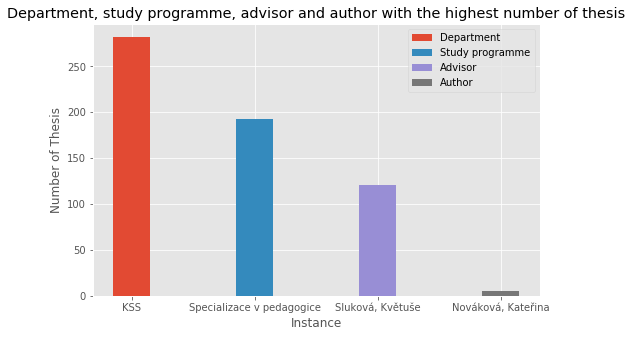

In [66]:
#Keywords to filter needed data from dataframe
keywords = ['local.department.abbreviation', 'local.degree.programme', 
            'dc.contributor.advisor', 'dc.contributor.author']
#"Prettified" keywords for visualization
keywords2 = ['Department', 'Study programme', 'Advisor', 'Author']
#list to store data like max value from each keyword
frames = []

#for each keyword collect max element in number of thesis per instance
for key in keywords:
    key_group = df.groupby([key]).size().reset_index(name='counts')
    max_key = key_group.loc[key_group['counts'].idxmax()]
    frames.append(list(max_key.values))

plt.figure(figsize=(8,5))
#plot each bar seperatly
for frame in frames:
    plt.bar(frame[0], frame[1], width = 0.3)
plt.title('Department, study programme, advisor and author with the highest number of thesis')
plt.xlabel('Instance')
plt.ylabel('Number of Thesis')
plt.legend(keywords2)

#Create dict to display table with exact numbers
dict_table = {'Instance of' : keywords2, 'Instance' : [frame[0] for frame in frames], 
              'Highest number of thesis' : [frame[1] for frame in frames]}
d = pd.DataFrame(data = dict_table)
print(d.to_string())

Text(0.5,1,'Fraction of theses advised by people with various degrees')

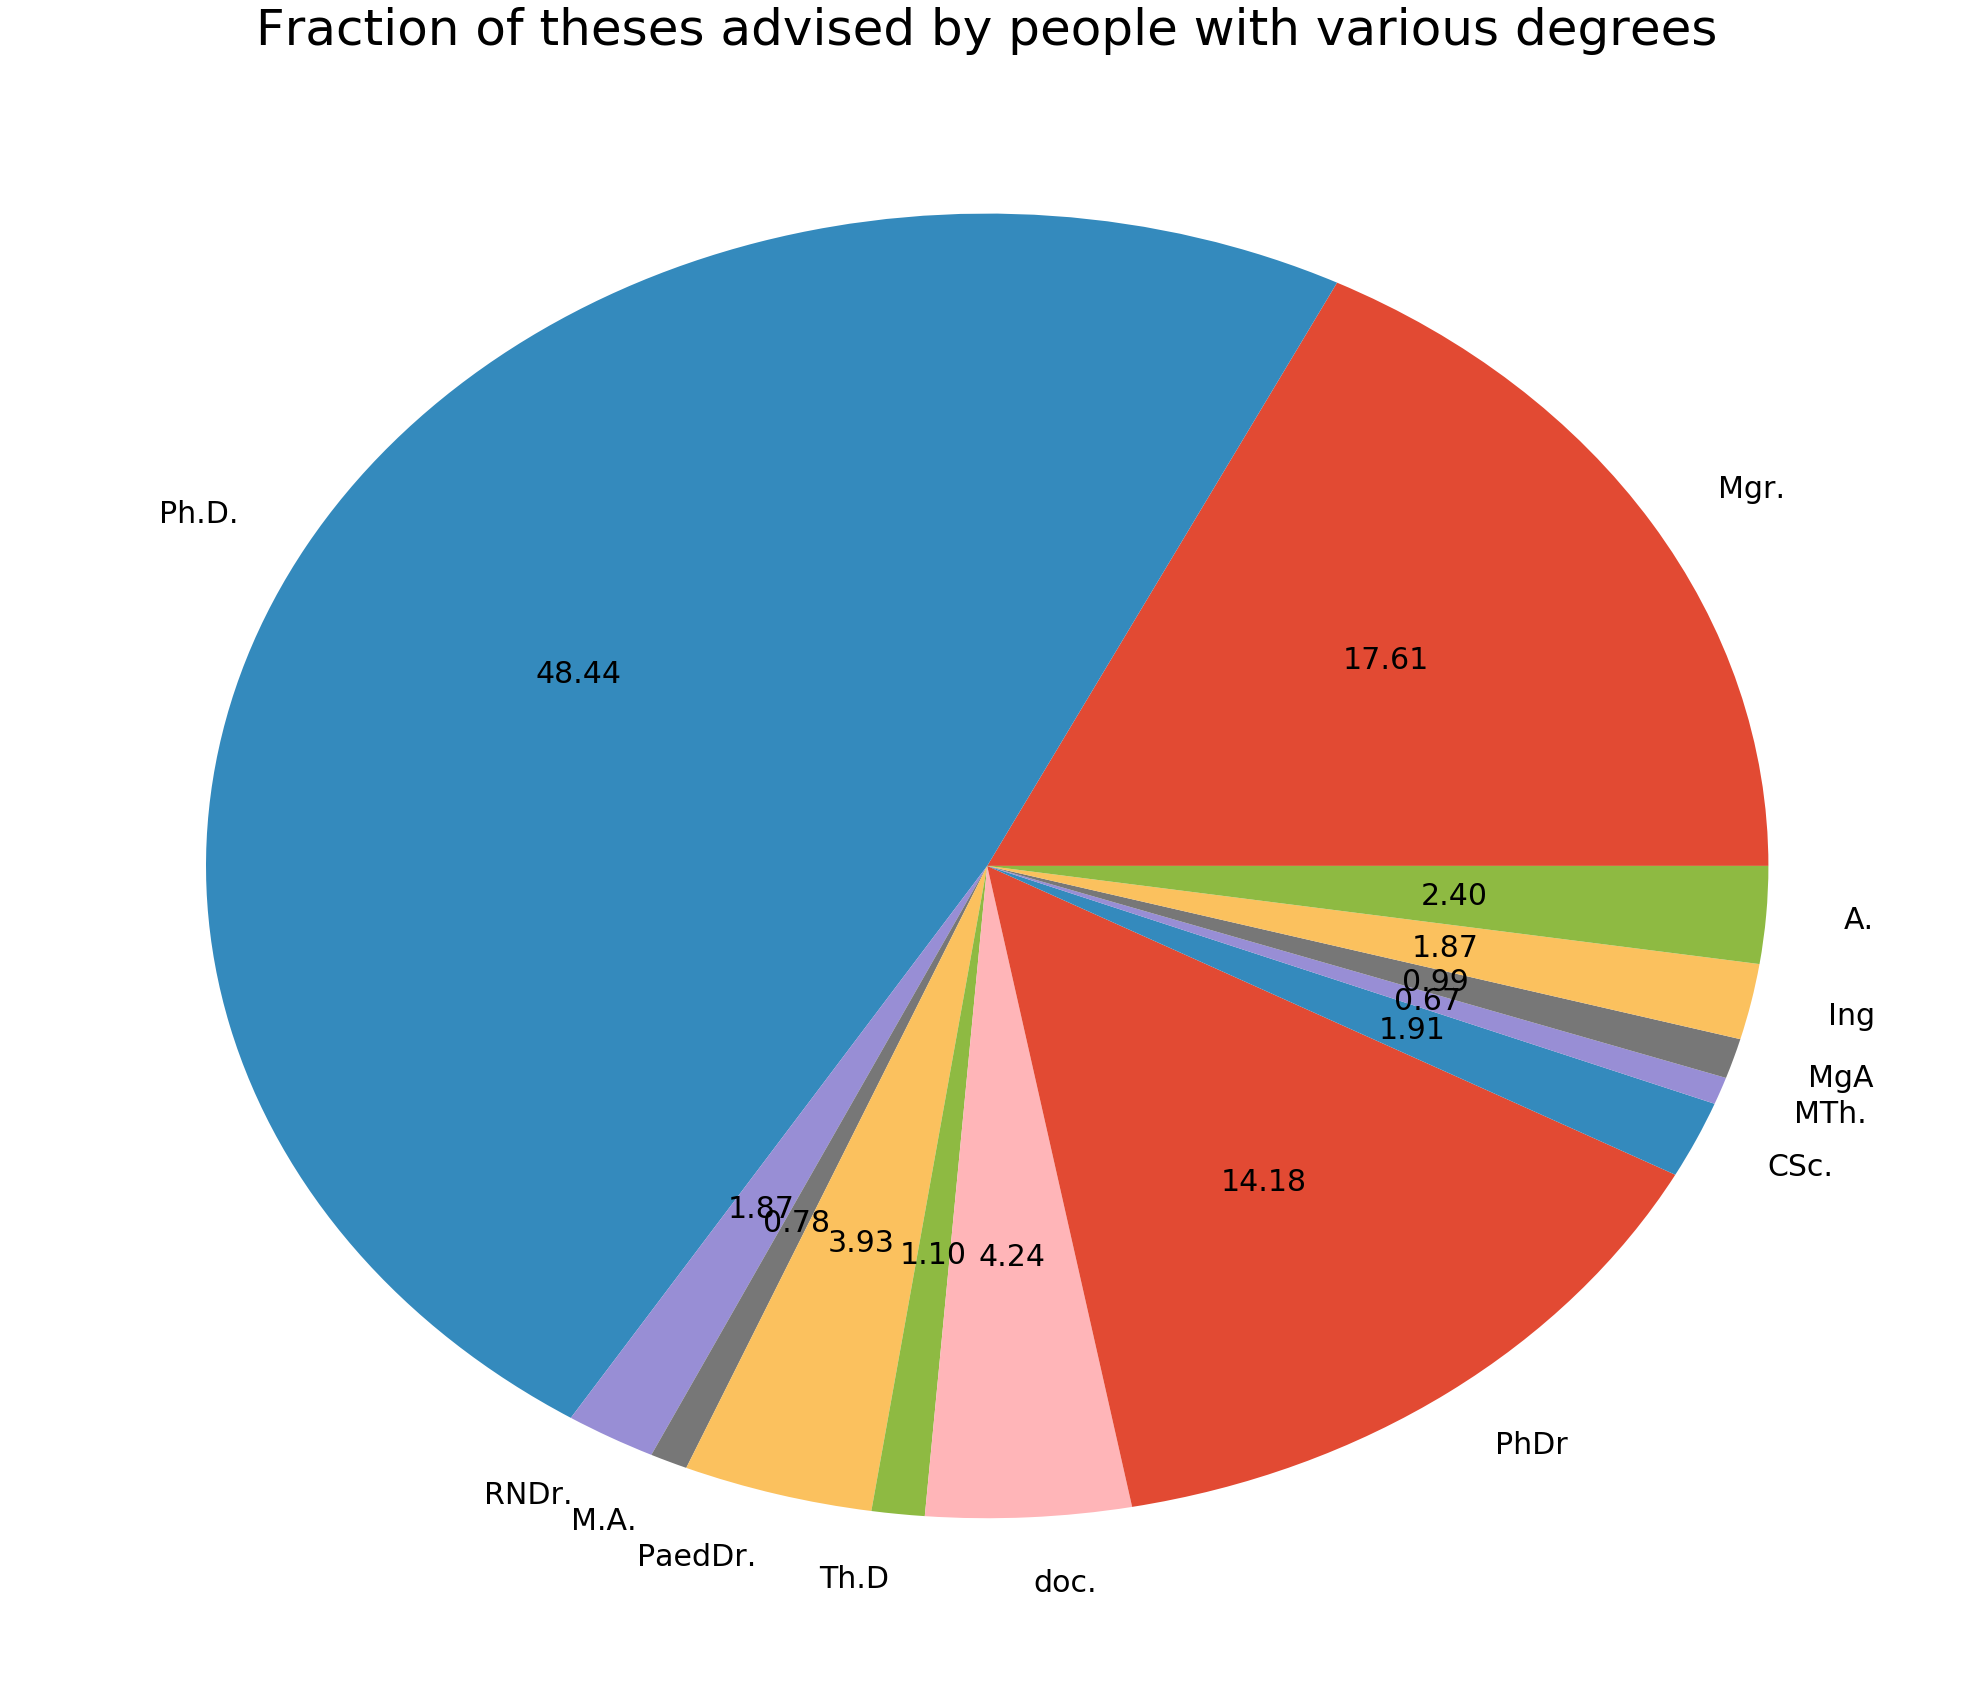

In [69]:
#List to filter names for the different titles
titles = ['Mgr.', 'Ph.D.', 'RNDr.', 'M.A.', 'PaedDr.', 
          'Th.D', 'doc.', 'PhDr', 'Ph.D.',
         'CSc.', 'MTh.', 'MgA', 'Ing', 'A.']
#Dictionary to count occurence of each title in the names of the advisors
count_dict= dict.fromkeys(titles, 0)
#Delete rows with NaN attributes in column advisor
df = df[pd.notnull(df['dc.contributor.advisor'])]
#List with every name in dc.contributor.advisor column 
names_list = list(df['dc.contributor.advisor'].values)

#Iterate trough names list to find matching titles
for name in names_list:
    for title in titles:
        if title in name:
            count_dict[title] += 1

plt.figure(figsize=(35,30))
#Plot piechart with percentages
plt.pie(x = count_dict.values(), labels = count_dict.keys(),
        autopct = '%.2f', textprops={'fontsize': 30})
plt.title('Fraction of theses advised by people with various degrees', fontsize = 50)

In [ ]:
"""
It was not possible to complete the third visualization task with the new server data because there is only one Faculty.
If i should complete complete visualization task, please get back to me.
"""